In [13]:
from typing import Dict, Tuple, List, Any
import datetime as dt
from pathlib import Path
import numpy as np
from kedro.framework.session import KedroSession
from kedro.framework.startup import bootstrap_project

In [2]:
metadata = bootstrap_project(Path.cwd().parent.parent)
with KedroSession.create(metadata.package_name,
        project_path=metadata.project_path,
        env="base",
    ) as session: 
    context = session.load_context()

/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(


2022-01-01 08:51:04,485 - kedro.framework.session.store - INFO - `save()` not implemented for `BaseSessionStore`. Skipping the step.


In [14]:
from typing import Dict, List
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit  # cross_val_score, KFold

def _cross_val_predict(estimator, X, y, cv):
    y_hat = y.copy()
    y_hat[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_hat[val_idx] = estimator.predict(X[val_idx])
    return y_hat

def train(features: pd.DataFrame, feature_columns: List[str], model_params: Dict[str,Any]):
    features = features.dropna()
    regressor = lgb.LGBMRegressor(**model_params["hyper_parameters"])
    cv_indicies = list(TimeSeriesSplit().split(features))
    features["y_hat_buy"] = _cross_val_predict(regressor, features[feature_columns].values, features["y_buy"].values, cv=cv_indicies)
    features["y_hat_sell"] = _cross_val_predict(regressor, features[feature_columns].values, features["y_sell"].values, cv=cv_indicies)
    return features


In [18]:
predicted = train(
    context.catalog.load("model_input"),
    context.params["data_params"]["features"], 
    context.params["model_params"]
)

2022-01-01 08:11:21,230 - kedro.io.data_catalog - INFO - Loading data from `model_input` (PickleDataSet)...


/tmp/ipykernel_13189/391304259.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["y_hat_buy"] = _cross_val_predict(regressor, features[feature_columns].values, features["y_buy"].values, cv=cv_indicies)
/tmp/ipykernel_13189/391304259.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["y_hat_sell"] = _cross_val_predict(regressor, features[feature_columns].values, features["y_sell"].values, cv=cv_indicies)


In [19]:
context.catalog.save("include_y_hat", predicted)

2022-01-01 08:11:26,904 - kedro.io.data_catalog - INFO - Saving data to `include_y_hat` (PickleDataSet)...


/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


In [20]:
predicted.tail()

,Open,High,Low,Close,Volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost,y_hat_buy,y_hat_sell
Date Time,,,,,,,,,,,,,,,,,,,,,
2021-12-31 10:50:00,48381.0,48405.0,48357.0,48378.0,7.278654e+06,108.320362,39.8,-28.720362,130.706039,-164.633915,...,48120.0,2.0,1.0,0.0,-0.004263,0.000000,-0.001075,0.000000,0.000014,0.000084
2021-12-31 10:55:00,48378.0,48379.0,47977.0,48057.0,8.035974e+07,451.452521,162.4,-126.652521,294.751817,28.084402,...,48120.0,1.0,0.0,1.0,0.000000,-0.000000,0.000000,-0.001311,0.001377,-0.000491
2021-12-31 11:00:00,48057.0,48208.0,48033.0,48101.0,2.323637e+07,470.027202,151.1,-167.827202,321.925586,78.804764,...,48137.0,3.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-0.000069,0.000324
2021-12-31 11:05:00,48101.0,48106.0,48038.0,48102.0,2.163131e+07,420.558446,131.8,-156.958446,342.589933,121.027037,...,48137.0,2.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-0.000251,0.000024
2021-12-31 11:10:00,48102.0,48112.0,48068.0,48078.0,1.858444e+07,290.334224,53.2,-183.934224,295.932135,95.605938,...,48137.0,1.0,0.0,1.0,0.000000,0.000353,0.000000,-0.001227,-0.000228,-0.001482


In [56]:
import matplotlib.pylab as plt
plt.style.use("ggplot")


def _plot_returns(features: pd.DataFrame):
    df = features.dropna()

    print('y_hatがプラスのときだけトレードした場合の累積リターン')
    df[df['y_hat_buy'] > 0]['y_buy'].cumsum().plot(label='buy')
    df[df['y_hat_sell'] > 0]['y_sell'].cumsum().plot(label='sale')
    (df['y_buy'] * (df['y_hat_buy'] > 0) + df['y_sell'] * (df['y_hat_sell'] > 0)).cumsum().plot(label='buy+sale')
    plt.title("cumsum return(=cumsum({y_hat>0})")
    plt.legend()
    plt.savefig(
        "../../../.."+"/".join(context.catalog.datasets.cumsum_return_with_y_hat._filepath.parts)
        ,bbox_inches="tight")
    plt.show()

2022-01-01 09:25:28,041 - kedro.io.data_catalog - INFO - Loading data from `include_y_hat` (PickleDataSet)...


/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")
/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'

y_hatがプラスのときだけトレードした場合の累積リターン


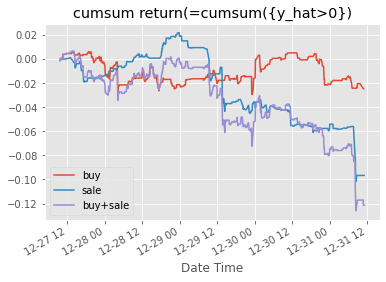

In [57]:
_plot_returns(context.catalog.load("include_y_hat"))

In [42]:
import numba

@numba.njit
def _backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

In [43]:
def calculate_cumsum_return_and_position(features: pd.DataFrame):
    features["cumsum_return"], features["possition"] = _backtest(
        cl=features["Close"].values,
        buy_entry=features["y_hat_buy"].values > 0,
        sell_entry=features["y_hat_sell"].values > 0,
        buy_cost=features["buy_cost"].values,
        sell_cost=features["sell_cost"].values,
    )
    return features

In [44]:
import pandas as pd
import matplotlib.pylab as plt
plt.style.use("ggplot")


def plot_cum_return(features: pd.DataFrame):
    df = features.dropna()
    df["cumsum_return"].plot()
    plt.title("cumsum_return")
    plt.show()

    df["possition"].plot()
    plt.title("possition")
    plt.savefig("../../../.."+"/".join(context.catalog.datasets.possition._filepath.parts))
    plt.show()

    df["possition"].rolling(1000).mean().plot()
    plt.title("Average possition")
    plt.savefig("../../../.."+"/".join(context.catalog.datasets.average_possition._filepath.parts))
    plt.show()

    df["possition"].diff(1).abs().dropna().cumsum().plot()
    plt.title("Transaction volume")
    plt.savefig("../../../.."+"/".join(context.catalog.datasets.transaction_volume._filepath.parts))
    plt.show()

2022-01-01 09:09:18,471 - kedro.io.data_catalog - INFO - Loading data from `include_y_hat` (PickleDataSet)...


/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


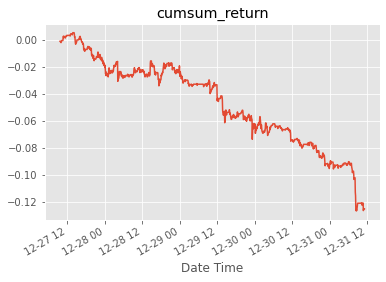

/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


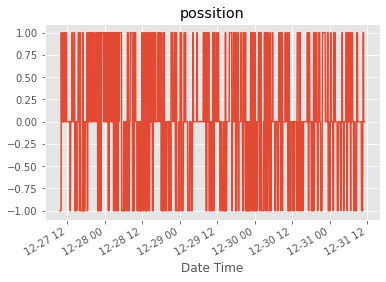

/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


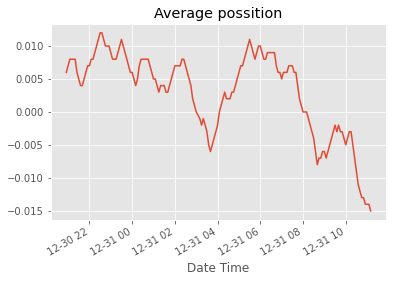

/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


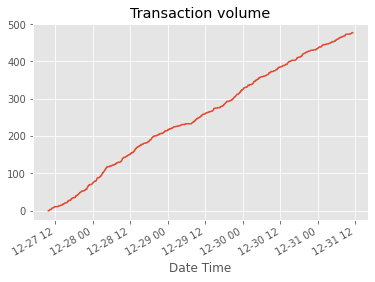

In [45]:
cum_res = calculate_cumsum_return_and_position(context.catalog.load("include_y_hat"))
plot_cum_return(cum_res)

In [12]:
context.catalog.save("reporting_input", cum_res)

2022-01-01 08:07:16,314 - kedro.io.data_catalog - INFO - Saving data to `reporting_input` (PickleDataSet)...


/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


In [65]:
from scipy.stats import ttest_1samp
import math
import mlflow
import datetime as dt
from collections import ChainMap

# p平均法 https://note.com/btcml/n/n0d9575882640
def _calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def _calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)


def p_test(features: pd.DataFrame, n_p_mean: int):
    df = features.dropna()
    print("t検定")
    x = df["cumsum_return"].diff(1).dropna()
    t, p = ttest_1samp(x, 0)
    print(f"t value: {t}")
    print(f"p value: {p}")

    p_mean = _calc_p_mean(x, n_p_mean)
    error_ratio = _calc_p_mean_type1_error_rate(p_mean, n_p_mean)
    print(f"n of p mean: {n_p_mean}")
    print(f"p mean: {p_mean}")
    print(f"error_ratio: {error_ratio}")

    with mlflow.start_run():
        mlflow.log_dict(context.params, "parameters.json")
        mlflow.log_metric("t value", t)
        mlflow.log_metric("p value", p)
        mlflow.log_metric("n of p mean", n_p_mean)
        mlflow.log_metric("p mean", p_mean)
        mlflow.log_metric("error_ratio", error_ratio)
        # logging images as artifact
        mlflow.log_artifact("../../../.."+"/".join(context.catalog.datasets.execution_prob._filepath.parts))
        mlflow.log_artifact("../../../.."+"/".join(context.catalog.datasets.average_time_to_exit._filepath.parts))
        mlflow.log_artifact("../../../.."+"/".join(context.catalog.datasets.time_distribution_to_exit._filepath.parts))
        mlflow.log_artifact("../../../.."+"/".join(context.catalog.datasets.cumsum_reaturn._filepath.parts))
        mlflow.log_artifact("../../../.."+"/".join(context.catalog.datasets.cumsum_return_with_y_hat._filepath.parts))
        mlflow.log_artifact("../../../.."+"/".join(context.catalog.datasets.possition._filepath.parts))
        mlflow.log_artifact("../../../.."+"/".join(context.catalog.datasets.average_possition._filepath.parts))
        mlflow.log_artifact("../../../.."+"/".join(context.catalog.datasets.transaction_volume._filepath.parts))
        mlflow.log_param("time of prediction", str(dt.datetime.now()))

In [66]:
p_test(context.catalog.load("reporting_input"), context.params["report_params"]["n_p_mean"])

2022-01-02 04:22:22,089 - kedro.io.data_catalog - INFO - Loading data from `reporting_input` (PickleDataSet)...
t検定
t value: -2.4540560240278575
p value: 0.014270665396453558
n of p mean: 5
p mean: 1.0
error_ratio: 26.041666666666668


In [15]:
# 最大ポジションサイズと月次利益の見積もり例
amount_per_day_jpy = 1000.0 * 10000 * 10000 # 1日の売買代金 1000億円
order_interval_min = 15.0 # 15分間隔で発注
monthly_return = 0.5 # 月次利益率 50%
my_order_ratio = 0.01 # 自分のボットの売買代金割合 1%

max_position_size = amount_per_day_jpy / (24 * 60) * order_interval_min * my_order_ratio
monthly_profit = max_position_size * monthly_return
print('最大ポジションサイズ {}円'.format(max_position_size))
print('月次利益 {}円'.format(monthly_profit))

最大ポジションサイズ 10416666.666666668円
月次利益 5208333.333333334円
